In [1]:
from numpy.random import seed
from tensorflow.random import set_seed
import random

seed(1)
set_seed(1)
random.seed(1)

import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer
from keras.callbacks import History 
from tensorflow.keras.optimizers import SGD, Adam

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import accuracy_score


from utils import k_fold, predict_and_accuracy, get_features, results_to_file

plt.style.use('ggplot')

### Preprocessing

- Standardise numerical cols 
- Create new features


In [2]:
df = pd.read_csv('../data/Data_A.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']


# engineer features
df, engineered_cols = get_features(df)


# do train test split
X = df.drop(columns='midprice_up')
y = df['midprice_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

means = X_train[price_cols+vol_cols+engineered_cols].mean(axis=0)
stds = X_train[price_cols+vol_cols+engineered_cols].std(axis=0)

def transform(df, means, stds):
    return (df-means)/stds

X_train[price_cols+vol_cols+engineered_cols] = transform(X_train[price_cols+vol_cols+engineered_cols], means, stds)
X_test[price_cols+vol_cols+engineered_cols] = transform(X_test[price_cols+vol_cols+engineered_cols], means, stds)



In [9]:
def get_default_model(shape: int=None):

    if shape is None:
        shape = len(X_train.columns)

    model = keras.Sequential([
        InputLayer(input_shape=(shape)),
        Dense(units=100, activation='elu'),
        Dense(units=50, activation='elu'),
        Dense(units=20, activation='elu'),
        Dense(units=1, activation='sigmoid')
    ])
    return model, History()

def get_basic_model(n, shape=None):

    if shape is None:
        shape = len(X_train.columns)


    basic_model  = keras.Sequential([
        InputLayer(input_shape=(shape)),
        Dense(units=n, activation='elu'),
        Dense(units=1, activation='sigmoid')        
    ])
    return basic_model

### Check adding engineered features

In [19]:
results = []

base_X_train = X_train[price_cols+vol_cols+prev_mid_m_cols]
base_X_test = X_test[price_cols+vol_cols+prev_mid_m_cols]

training_dict = {'Base Features':(base_X_train, base_X_test), 'Engineered Features':(X_train, X_test)}

for k, data in training_dict.items():
    
    model = get_basic_model(100, shape=data[0].shape[1])

    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(data[0], y_train, batch_size=100, epochs=5, callbacks=[History()], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  data[0], data[1], y_train, y_test)

    results.append({'Features': k, 'Train Accuracy': train_a, 'Test Accuracy': test_a})

results_to_file(results, './tables/features_table.tex')


,Features,Train Accuracy,Test Accuracy
0,Base Features,0.753038,0.75335
1,Engineered Features,0.759912,0.76000


### Tune model shape

In [15]:
results = []

models = {
        'Basic Model - 20': get_basic_model(20), 
        'Basic Model - 50': get_basic_model(50),
        'Basic Model - 100': get_basic_model(100),
        'Basic Model - 200': get_basic_model(200),
        'Larger Model': get_default_model()[0]
        }

for k, model in models.items():
    
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=100, epochs=5, callbacks=[History()], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    results.append({'Model': k, 'Train Accuracy': train_a, 'Test Accuracy': test_a})

results_to_file(results, './tables/models_table.tex')


,Model,Train Accuracy,Test Accuracy
0,Basic Model - 20,0.759813,0.75885
1,Basic Model - 50,0.760463,0.75945
2,Basic Model - 100,0.760150,0.75905
3,Basic Model - 200,0.760387,0.76020
4,Larger Model,0.764475,0.76425


### Tune Epochs

In [18]:
results = []

for epochs in [2, 5, 10, 20]:
    
    model, history = get_default_model()
    model.compile(optimizer=Adam(0.003), loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(X_train, y_train, batch_size=100, epochs=epochs, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    results.append({'Epochs': epochs, 'Train Accuracy': train_a, 'Test Accuracy': test_a})

results_to_file(results, './tables/epochs_table.tex')


,Epochs,Train Accuracy,Test Accuracy
0,2,0.760125,0.75985
1,5,0.767312,0.76505
2,10,0.769687,0.76980
3,20,0.775600,0.76880


### Tune optimizer

In [14]:
results = []

for optimizer in [Adam(), SGD()]:
    
    model, history = get_default_model()
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(X_train, y_train, batch_size=100, epochs=10, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    results.append({'Optimizer': optimizer.get_config()['name'], 'Train Accuracy': train_a, 'Test Accuracy': test_a})

results_to_file(results, './tables/optimizer_table.tex')

,Optimizer,Train Accuracy,Test Accuracy
0,Adam,0.769813,0.76875
1,SGD,0.759175,0.75990


### Tune batch size

In [15]:
results = []

for batch_size in [50, 100, 500, 1000]:
    
    model, history = get_default_model()
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    results.append({'Batch Size': batch_size, 'Train Accuracy': train_a, 'Test Accuracy': test_a})


results_to_file(results, './tables/batch_table.tex')

,Batch Size,Train Accuracy,Test Accuracy
0,50,0.770138,0.76870
1,100,0.769737,0.76745
2,500,0.763475,0.76280
3,1000,0.762288,0.76090


#### Tune Eta

In [14]:
results = []

for eta in [0.001, 0.003, 0.01, 0.05]:

    model, history = get_default_model()

    model.compile(optimizer=Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(X_train, y_train, batch_size=100, epochs=10, callbacks=[history], verbose=0)
    train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
    
    results.append({'Learning Rate':f"{eta}", 'Train Accuracy': train_a, 'Test Accuracy': test_a})

results_to_file(results, './tables/eta_table.tex')


,Learning Rate,Train Accuracy,Test Accuracy
0,0.001,0.768525,0.76785
1,0.003,0.771412,0.76900
2,0.01,0.763900,0.76015
3,0.05,0.502800,0.50220


#### Do 5 fold Cross Validation to check for model stability
We want to ensure the model is stable over different train test windows  

train: 0.7698, test: 0.7684
Time taken: 118.9s


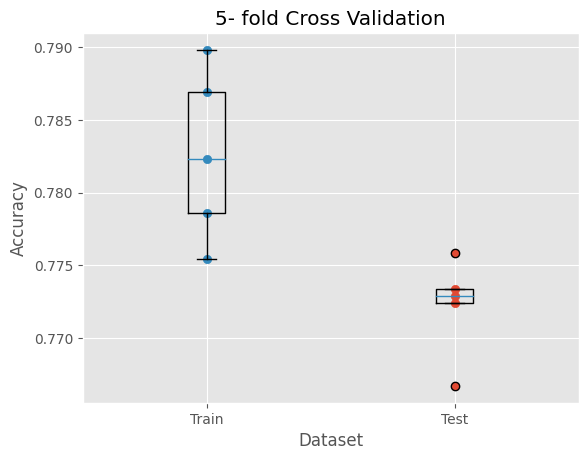

In [17]:
eta = 0.003
batch_size=100
optimizer=Adam(eta)
epochs=10


model, history = get_default_model()
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[history], verbose=0)
train_a, test_a = predict_and_accuracy(model,  X_train, X_test, y_train, y_test)
print(f"train: {train_a:.4f}, test: {test_a:.4f}")

k_fold(model, X_train, y_train, batch_size=batch_size, epochs=epochs, history=history)
plt.savefig('./plots/kfold_cv.png')
